<div style="text-align: center;">
<strong>Machine Learning for Scientific Computing and Numerical Analysis - PC 2</strong>
</div>
<div style="text-align: center;">
<strong>Multilayer perceptron</strong>
</div>
<div style="text-align: center;">
<p>Loïc Gouarin, Samuel Kokh, Hadrien Montanelli</p>
</div>
<div style="text-align: center;">
<i>2024 - 2025</i>
</div>

# Introduction

In this session, we will implement a multilayer perceptron in order to gain a better understanding of the basic algorithms that make up neural networks. Lecture 2 introduces two important steps in all neural network methods:

- the forward pass;
- backpropagation.

We recall here the notations used during the second lecture and all over this session.

Let $d_0,\ldots,d_{L+1}$ be positive integers such that $d_0=d$ and $d_{L+1}=1$. An artificial neural network $\hat{f}(\cdot;\bm{w}):\R^d\to\R$ is a composition of artificial neurons, i.e., $\hat{f}(\cdot;\bm{w}) = a^{(L+1)} \circ \ldots \circ \bm{a}^{(0)}$ with

$$
\begin{align}
& \bm{a}^{(0)}:\R^d\to\R^d, && \bm{a}^{(0)}(\bm{x}) = \bm{x}, \\
& \bm{a}^{(\ell)}:\R^{d_{\ell-1}}\to\R^{d_\ell}, && \bm{a}^{(\ell)}(\bm{x}) = \sigma\left(W^{(\ell-1)}\bm{x} + \bm{b}^{(\ell-1)}\right), \quad 1\leq\ell\leq L, \\
& a^{(L+1)}:\R^{d_L}\to\R, && a^{(L+1)}(\bm{x}) = W^{(L)}\bm{x} + b^{(L)}.
\end{align}
$$

Here, $\sigma$ is the activation function. Various activation functions are used in artificial neural networks. We introduce three of them: sigmoid, hyperbolic tangent, and ReLU. The forward pass uses the activation function and backpropagation its derivative. They can be implemented as follows in Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import time
np.random.seed(seed=42)

In [2]:
class sigmoid:
    def __call__(self, x):
        return 1.0 / (1 + np.exp(-x))

    def diff(self, x):
        f = self(x)
        return f * (1 - f)

In [3]:
class tanh:
    def __call__(self, x):
        return np.tanh(x)

    def diff(self, x):
        f = self(x)
        return 1 - f**2

In [4]:
class ReLU:
    def __call__(self, x):
        return np.maximum(0, x)

    def diff(self, x):
        grad = np.zeros_like(x)
        grad[x > 0] = 1
        return grad

In [5]:
activation_functions = [sigmoid, tanh, ReLU]

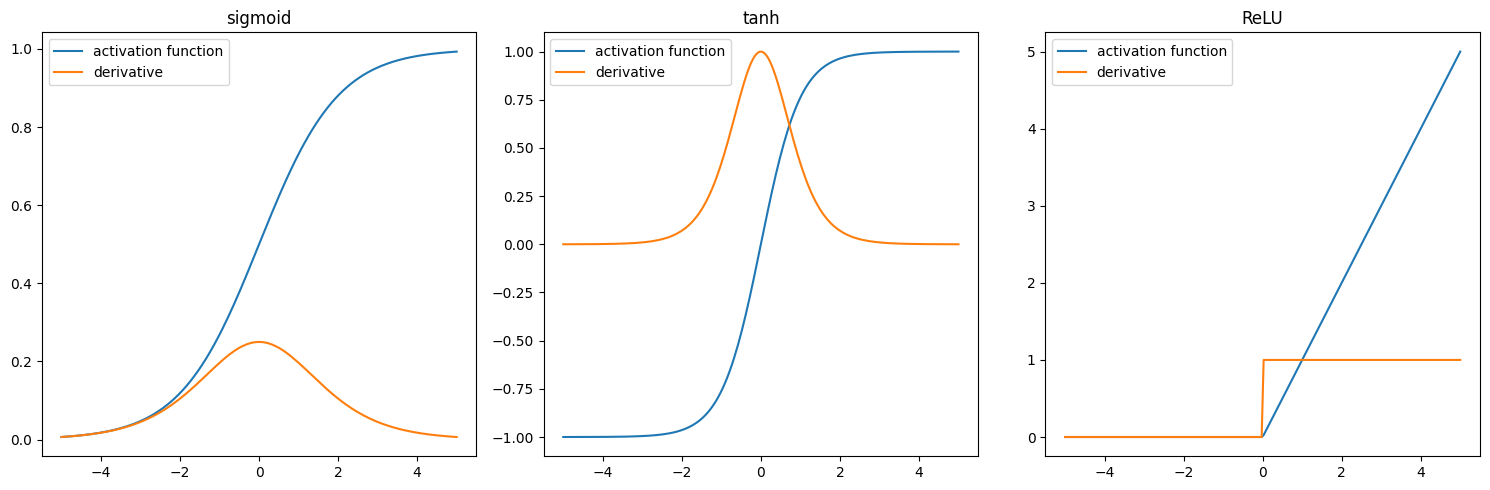

In [6]:
x = np.linspace(-5, 5, 200)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ia, a in enumerate(activation_functions):
    ax[ia].plot(x, a()(x), label="activation function")
    ax[ia].plot(x, a().diff(x), label="derivative")
    ax[ia].set_title(a.__name__)
    ax[ia].legend()

fig.tight_layout()

We will utilize the dataset of the previous PC and give a function to initialize the weights and the biases of the neural network.

In [7]:
def get_dataset(datatype, n, d, eta, *, random_gen=np.random.rand, seed=42):
    x = -1 + 2 * random_gen(n, d)
    if datatype == "linear":
        w_linear = np.ones(d)
        y = x @ w_linear + eta * random_gen(n)
    elif datatype == "logist":
        w_logistic = np.ones(d)
        y = 1 / (1 + np.exp(-x @ w_logistic)) + eta * random_gen(n)
    elif datatype == "normal":
        mean = np.zeros(d)
        covariance = np.eye(d) / d
        mvn = multivariate_normal(mean=mean, cov=covariance)
        y = mvn.logpdf(x) + eta * random_gen(n)
    elif datatype == "sphere":
        y = np.linalg.norm(x, axis=1) + eta * random_gen(n)
    y /= np.max(np.abs(y))
    return x, y

In [10]:
def init(d, d1, L, *, eps=1e-2):
    """
    Initializes the weights and biases of a neural network randomly.

    Parameters
    ----------
    d: int
        The size of one entry of the data set.
    d1: int
        The number of neurons in one layer.
    L: int
        The number of hidden layers.
    eps: double
        The perturbation size.

    Returns
    -------
    weights: list
        A list of weights matrices of sizes [(d, d1), (d1, d1), ..., (d1, 1)].
    biases: list
        A list of biases vectors of sizes [(d1), ..., (1)].
    """
    np.random.seed(42)

    weights = []
    biases = []

    previous_size = d

    for l in range(L):
        biases.append(np.zeros([d1, 1]))
        stddev = np.sqrt(2.0 / (previous_size + d1))
        weights.append(
            np.random.normal(loc=0.0, scale=stddev, size=(d1, previous_size))
        )
        previous_size = d1

    biases.append(np.zeros([1, 1]))
    stddev = np.sqrt(2.0 / (previous_size + 1))
    weights.append(np.random.normal(loc=0.0, scale=stddev, size=(1, previous_size)))

    return weights, biases

# 1 Shallow networks

Let's take this simple example to illustrate the forward pass and backpropagation. We have an input in two dimensions ($d_0=d=2$), followed by a single hidden layer ($L=1$) with three neurons ($d_1=3)$ and finally, a scalar output ($d_2=1$). The forward pass can be written as:

$$
\begin{aligned}
&\boldsymbol{a}^{(0)} = (x_1, x_2)^T \in \R^2, \\ \\
&\boldsymbol{z}^{(0)} = \left[
\begin{array}{cc}
W^{(0)}_{1, 1} & W^{(0)}_{1, 2} \\
W^{(0)}_{2, 1} & W^{(0)}_{2, 2} \\
W^{(0)}_{3, 1} & W^{(0)}_{3, 2}
\end{array}
\right]
\left(
\begin{array}{c}
a^{(0)}_1 \\
a^{(0)}_2
\end{array}
\right)
+
\left(
\begin{array}{c}
b^{(0)}_1 \\
b^{(0)}_2 \\
b^{(0)}_3
\end{array}
\right) \in \R^3, \\ \\
& \boldsymbol{a}^{(1)} = \sigma\left(\boldsymbol{z}^{(0)}\right) \in \R^3, \\ \\
& a^{(2)} = z^{(1)} = \left[
\begin{array}{cccc}
W^{(1)}_{1, 1} & W^{(1)}_{1, 2} & W^{(1)}_{1, 3}
\end{array}
\right]
\left(
\begin{array}{c}
a^{(1)}_1 \\
a^{(1)}_2 \\
a^{(1)}_3
\end{array}
\right)
+
b^{(1)}_1 \in \R.
\end{aligned}
$$

This is done for each entry in the data set. Therefore, if the data set is of size $(n, 2)$, each variable that appears in the forward pass will be of size

$$
\begin{aligned}
&\boldsymbol{a}^{(0)}: (2, n), \\
&\boldsymbol{z}^{(0)}: (3, n), \\
&\boldsymbol{a}^{(1)}: (3, n), \\
&\boldsymbol{a}^{(2)}: (1, n).
\end{aligned}
$$

## 1.1 Forward pass

### Exercise

{exercise}
Given the following implementation of the forward pass, fill in the blanks.

In [11]:
def forward_pass_shallow(X, weights, biases, activation=sigmoid()):
    """
    Performs a forward pass through a shallow neural network.

    Parameters
    ----------
    X: numpy.ndarray
        Input data of shape (n, d).
    weights: list of numpy.ndarray
        List of weight matrices for each layer.
    biases: list of numpy.ndarray
        List of bias vectors for each layer.
    activation: callable, optional
        Activation function to use. Default is sigmoid().

    Returns
    -------
    Z: list of numpy.ndarray
        List of linear transformation results for each layer.
    A: list of numpy.ndarray
        List of activations for each layer, including the input data as the first element.
    """
    Z, A = [], [X.T]

    z = weights[0] @ X.T + biases[0]  
    a = activation(z)  
    Z.append(z)
    A.append(a)

    A.append(weights[1] @ a + biases[1])  

    return Z, A

### Validation

In [12]:
# Setup (data):
n = 5
d = 2
eta = 1e-2
X, y = get_dataset("linear", n, d, eta)

# Setup (NN):
d1 = 3
L = 1
weights, biases = init(d, d1, L)

# Forward pass:
Z, A = forward_pass_shallow(X, weights, biases)
print(len(Z), len(A))
print(Z)
print(A)
print(A[0].shape)
print(Z[0].shape)
print(A[1].shape)
print(A[2].shape)

1 3
[array([[-0.15765269,  0.12850703, -0.1559594 , -0.34169702,  0.02714025],
       [ 0.76551459,  0.38013061, -0.94453869,  0.34338923,  0.4836916 ],
       [-0.09632553, -0.09793164,  0.203763  ,  0.02244059, -0.09157185]])]
[array([[-0.25091976,  0.46398788, -0.68796272, -0.88383278,  0.20223002],
       [ 0.90142861,  0.19731697, -0.68801096,  0.73235229,  0.41614516]]), array([[0.46066826, 0.53208262, 0.46108899, 0.41539731, 0.50678464],
       [0.68254981, 0.5939046 , 0.27998446, 0.58501357, 0.61861921],
       [0.47593722, 0.47553664, 0.55076523, 0.50560991, 0.47712302]]), array([[0.72681053, 0.75858588, 0.48398438, 0.61347848, 0.7432213 ]])]
(2, 5)
(3, 5)
(3, 5)
(1, 5)


## 1.2 Backpropagation

The backward pass in our example for a given $y\in\R$ can be written as follows:

$$
\begin{aligned}
&\delta b^{(1)} = \delta z^{(1)} = 2(a^{(2)} - y) \in \R, \\
&\delta \boldsymbol{W}^{(1)} = \delta z^{(1)} (\boldsymbol{a}^{(1)})^T \in \R^{1\times 3}, \\
&\delta \boldsymbol{b}^{(0)} = \delta \boldsymbol{z}^{(0)} = \sigma'(\boldsymbol{z}^{(0)})(\boldsymbol{W}^{(1)})^T \delta z^{(1)} \in \R^3, \\
&\delta \boldsymbol{W}^{(0)} = \delta \boldsymbol{z}^{(0)} (\boldsymbol{a}^{(0)})^T \in \R^{3\times 2}.
\end{aligned}
$$

This is also done for each entry in the data set. An extra $1/n$ factor will also appear.

### Exercise

{exercise}
Given the following implementation of backward propagation, fill in the blanks and justify the $1/n$ factor.

In [13]:
def backpropagation_shallow(X, y, weights, biases, activation=sigmoid()):
    """
    Performs backpropagation to compute the gradients of the loss function with respect to weights and biases.

    Parameters
    ----------
    X: numpy.ndarray
        Input data of shape (n, d)
    y: numpy.ndarray
        True labels of shape (n).
    weights: list of numpy.ndarray
        List of weight matrices for each layer.
    biases: list of numpy.ndarray
        List of bias vectors for each layer.
    activation: callable, optional
        Activation function to use. Default is sigmoid().

    Returns
    -------
    dW: list of numpy.ndarray
        Gradients of the loss with respect to weights for each layer.
    db: list of numpy.ndarray
        Gradients of the loss with respect to biases for each layer.
    """
    n = y.shape[0]

    Z, A = forward_pass_shallow(X, weights, biases, activation)

    dW = [np.empty_like(w) for w in weights]
    db = [np.empty_like(b) for b in biases]

    dZ = 2 * (A[2] - y.T)
    db[1] = np.sum(dZ, axis=1, keepdims=True) / n
    dW[1] = dZ @ A[1].T / n

    dZ = activation.diff(Z[0]) * (weights[1].T @ dZ)  
    db[0] = np.sum(dZ, axis=1, keepdims=True) / n  
    dW[0] = dZ @ A[0].T / n 
    
    return dW, db

***Comments on exercice 2***

During backpropagation, the factor $\frac{1}{n}$ appears due to the definition of the mean cost function. We have:

$$
J(w) = \frac{1}{n} \sum_{i=1}^n \left( \hat{f}(x_i;w) - y_i \right)^2,
$$

To obtain the gradient of the weights $W$ and biases $b$, we compute the partial derivatives of $J$:

$$
\frac{\partial J}{\partial W^{(k)}} = \frac{1}{n} \sum_{i=1}^n \frac{\partial}{\partial W^{(k)}} \left( \left( \hat{f}(x_i;w) - y_i \right)^2 \right),
$$

and similarly for $b$. The factor $\frac{1}{n}$ therefore remains and ensures that the gradients represent the average contribution of each example.



### Validation

In [14]:
# Setup (data):
n = 5
d = 2
eta = 1e-2
X, y = get_dataset("linear", n, d, eta)

# Setup (NN):
d1 = 3
L = 1
weights, biases = init(d, d1, L)

# Backpropagation:
dW, db = backpropagation_shallow(X, y, weights, biases)
print(len(dW), len(db))
print(dW)
print(db)
print(db[1].shape)
print(dW[1].shape)
print(db[0].shape)
print(dW[0].shape)

2 2
[array([[-0.18556107, -0.26184868],
       [-0.08135511, -0.11384243],
       [ 0.0550638 ,  0.0777791 ]]), array([[1.06972944, 0.81739565, 1.16097606]])]
[array([[ 0.61290041],
       [ 0.27493153],
       [-0.18218312]]), array([[2.20303101]])]
(1, 1)
(1, 3)
(3, 1)
(3, 2)


## 1.3 Gradient descent

We provide the following function to compute the MSE.

In [15]:
def MSE_shallow(X, y, weights, biases, activation=sigmoid()):
    """
    Computes the Mean Squared Error (MSE) between the predicted outputs and the actual targets.

    Parameters
    ----------
    X: numpy.ndarray
        Input data of shape (n, d).
    y: numpy.ndarray
        Actual target values of shape (n).
    weights: list of numpy.ndarray
        List of weight matrices for each layer in the neural network.
    biases: list of numpy.ndarray
        List of bias vectors for each layer in the neural network
    activation: callable, optional
        Activation function to use. Default is sigmoid().

    Returns
    -------
    float
        The mean squared error between the predicted outputs and the actual targets.
    """
    _, A = forward_pass_shallow(X, weights, biases, activation)
    return np.square(A[-1] - y.T).mean()

### Exercise

{exercise}
Given the following implementation of gradient descent, fill in the blanks.

In [16]:
def gradient_descent(
    X,
    y,
    XX,
    yy,
    weights,
    biases,
    *,
    activation=sigmoid(),
    learning_rate=0.01,
    epoch=1000,
):
    """
    Performs gradient descent to minimize the mean squared error (MSE).

    Parameters
    ----------
    X: numpy.ndarray
        Input features matrix (training set).
    y: numpy.ndarray
        Target values vector (training set).
    XX: numpy.ndarray
        Input features matrix (testing set).
    yy: numpy.ndarray
        Target values vector (testing set).
    weights: list of numpy.ndarray
        List of weight matrices for each layer.
    biases: list of numpy.ndarray
        List of bias vectors for each layer.
    activation: callable, optional
        Activation function to use. Default is sigmoid().
    learning_rate: float, optional
        Learning rate for gradient descent updates. Default is 0.01.
    epoch: int, optional
        Number of iterations for gradient descent. Default is 1000.

    Returns
    -------
    error_train: numpy.ndarray
        Array of MSE values for each epoch (training set).
    error_test: numpy.ndarray
        Array of MSE values for each epoch (testing set).
    """
    error_train = np.empty(epoch + 1)
    error_train[0] = MSE_shallow(X, y, weights, biases, activation)  
    error_test = np.empty(epoch + 1)
    error_test[0] = MSE_shallow(XX, yy, weights, biases, activation)  
    ie = 1

    for i in range(epoch):
        dW, db = backpropagation_shallow(X, y, weights, biases, activation) 

        for i in range(len(biases)):
            biases[i] -= db[i] * learning_rate  
            weights[i] -= dW[i] * learning_rate  

        error_train[ie] = MSE_shallow(X, y, weights, biases, activation) 
        error_test[ie] = MSE_shallow(XX, yy, weights, biases, activation)  
        ie += 1

    return error_train, error_test

### Validation

Time:           3.92s
MSE (training): 5.10e-04
MSE (testing):  8.56e-03


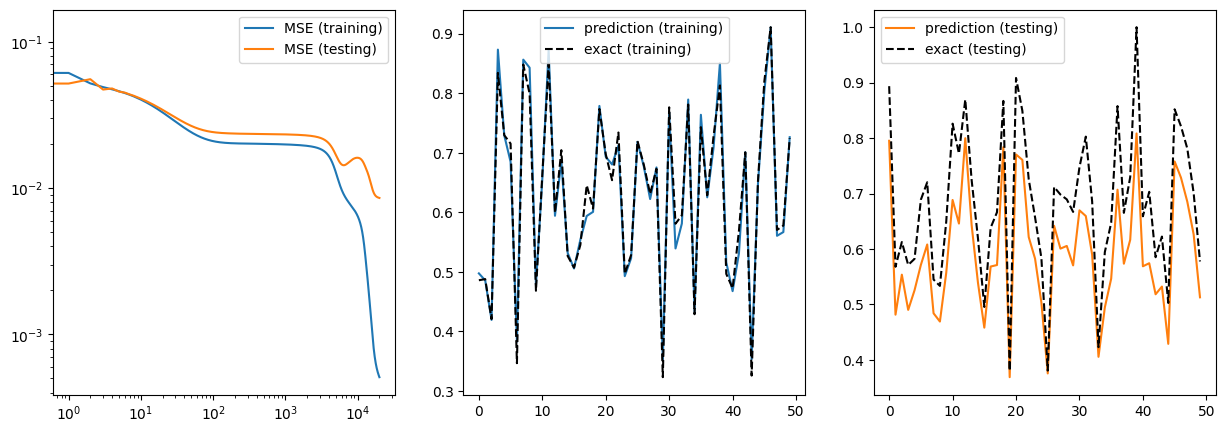

In [17]:
# Setup (data):
d = 5
n = 20 * d
eta = 1e-2
data = "sphere"
X, y = get_dataset(data, n, d, eta)
XX, yy = get_dataset(data, n, d, eta, seed=43)

# Setup (NN):
d1 = 2 * d
L = 1

# Setup (optim):
lr = 2e-1
ep = 20000

# Initialize:
weights, biases = init(d, d1, L)

# Optimize:
t0 = time.time()
error_train, error_test = gradient_descent(
    X, y, XX, yy, weights, biases, learning_rate=lr, epoch=ep
)
t1 = time.time()
print(f"Time:           {t1-t0:.2f}s")

# Compute prediction and errors:
_, A = forward_pass_shallow(X, weights, biases)
_, AA = forward_pass_shallow(XX, weights, biases)
print(f"MSE (training): {np.square(A[-1][0] - y).mean():.2e}")
print(f"MSE (testing):  {np.square(AA[-1][0] - yy).mean():.2e}")

# Plot:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].loglog(error_train, "-", label="MSE (training)")
axs[0].loglog(error_test, "-", label="MSE (testing)")
axs[0].legend()
n_disp = min(n, 50)
axs[1].plot(A[-1][0][:n_disp], "-", color="tab:blue", label="prediction (training)")
axs[1].plot(y[:n_disp], "--k", label="exact (training)")
axs[1].legend()
axs[2].plot(AA[-1][0][:n_disp], "-", color="tab:orange", label="prediction (testing)")
axs[2].plot(yy[:n_disp], "--k", label="exact (testing)")
axs[2].legend()

# 2 Deep networks

In this section, we modify the previous functions to be able

- to change the number of hidden layers;
- to implement stochastic gradient descent;
- to shuffle the data if needed.

## 2.1 Forward pass

### Exercise

{exercise}
Given the following implementation of the forward pass, fill in the blanks.

In [18]:
def forward_pass_deep(X, weights, biases, activation=sigmoid()):
    """
    Performs a forward pass through a deep neural network.

    Parameters
    ----------
    X: numpy.ndarray
        Input data of shape (n, d).
    weights: list of numpy.ndarray
        List of weight matrices for each layer.
    biases: list of numpy.ndarray
        List of bias vectors for each layer.
    activation: callable, optional
        Activation function to use. Default is sigmoid().

    Returns
    -------
    Z: list of numpy.ndarray
        List of linear transformation results for each layer.
    A: list of numpy.ndarray
        List of activations for each layer, including the input data as the first element.
    """
    L = len(weights) - 1

    Z, A = [], [X.T]

    for l in range(1, L + 1):
        z = weights[l-1] @ A[l-1] + biases[l-1]  
        a = activation(z)  
        Z.append(z)
        A.append(a)

    A.append(weights[L] @ A[L] + biases[L]) 

    return Z, A

### Validation

In [19]:
# Setup (data):
n = 5
d = 2
eta = 1e-2
X, y = get_dataset("linear", n, d, eta)

# Setup (NN):
d1 = 3
L = 2
weights, biases = init(d, d1, L)

# Forward pass:
Z, A = forward_pass_deep(X, weights, biases)
print(len(Z), len(A))
print(Z)
print(A)

2 4
[array([[-0.02991647, -0.08818562,  0.12020368,  0.24814486, -0.27630346],
       [-0.97934357, -0.49164007,  0.45311319,  0.26370329,  0.0991611 ],
       [ 0.17934278,  0.10775799, -0.10874485, -0.10645701,  0.0495147 ]]), array([[ 0.42238519,  0.46112255,  0.6259708 ,  0.63441606,  0.4869308 ],
       [-0.0652355 , -0.09349806, -0.12469322, -0.1026523 , -0.1430545 ],
       [-0.77525802, -0.87718906, -1.07220134, -1.01771184, -1.02968451]])]
[array([[-0.33820395, -0.37803536,  0.45921236,  0.77442549, -0.76081151],
       [-0.8728833 , -0.34963336,  0.27511494, -0.05557015,  0.42648957]]), array([[0.49252144, 0.47796787, 0.53001479, 0.56171983, 0.43136026],
       [0.27302205, 0.37950728, 0.61137917, 0.56554642, 0.52476998],
       [0.54471591, 0.52691346, 0.47284055, 0.47341085, 0.51237615]]), array([[0.60405386, 0.61328044, 0.65157529, 0.65349012, 0.61938314],
       [0.48369691, 0.4766425 , 0.46886702, 0.47435944, 0.46429724],
       [0.31534279, 0.29376061, 0.25498468, 0.265

We provide the following function.

In [20]:
def MSE_deep(X, y, weights, biases, activation=sigmoid()):
    """
    Computes the Mean Squared Error (MSE) between the predicted outputs and the actual targets.

    Parameters
    ----------
    X: numpy.ndarray
        Input data of shape (n, d).
    y: numpy.ndarray
        Actual target values of shape (n).
    weights: list of numpy.ndarray
        List of weight matrices for each layer in the neural network.
    biases: list of numpy.ndarray
        List of bias vectors for each layer in the neural network
    activation: callable, optional
        Activation function to use. Default is sigmoid().

    Returns
    -------
    float
        The mean squared error between the predicted outputs and the actual targets.
    """
    _, A = forward_pass_deep(X, weights, biases, activation)
    return np.square(A[-1] - y.T).mean()

## 2.2 Backpropagation

### Exercise

{exercise}
Given the following implementation of backpropagation, fill in the blanks.

In [21]:
def backpropagation_deep(X, y, weights, biases, activation=sigmoid()):
    """
    Performs backpropagation to compute the gradients of the loss function with respect to weights and biases.

    Parameters
    ----------
    X: numpy.ndarray
        Input data of shape (n, d)
    y: numpy.ndarray
        True labels of shape (n).
    weights: list of numpy.ndarray
        List of weight matrices for each layer.
    biases: list of numpy.ndarray
        List of bias vectors for each layer.
    activation: callable, optional
        Activation function to use. Default is sigmoid().

    Returns
    -------
    dW: list of numpy.ndarray
        Gradients of the loss with respect to weights for each layer.
    db: list of numpy.ndarray
        Gradients of the loss with respect to biases for each layer.
    """
    L = len(weights) - 1
    n = y.shape[0]

    Z, A = forward_pass_deep(X, weights, biases, activation) 

    dW = [np.empty_like(w) for w in weights]
    db = [np.empty_like(b) for b in biases]

    dZ = 2 * (A[L + 1] - y.T)
    db[L] = np.sum(dZ, axis=1, keepdims=True) / n
    dW[L] = dZ @ A[L].T / n

    for l in range(L, 0, -1):
        dZ = activation.diff(Z[l-1])*(weights[l].T @ dZ) 
        db[l - 1] = np.sum(dZ, axis=1, keepdims=True) / n  
        dW[l - 1] = dZ @ A[l - 1].T / n

    return dW, db

### Validation

In [22]:
# Setup (data):
n = 5
d = 2
eta = 1e-2
X, y = get_dataset("linear", n, d, eta)

# Setup (NN):
d1 = 3
L = 2
weights, biases = init(d, d1, L)

# Backpropagation:
dW, db = backpropagation_deep(X, y, weights, biases)
print(len(dW), len(db))
print(dW)
print(db)

3 3
[array([[ 0.00173826,  0.0173285 ],
       [ 0.00064139,  0.00495148],
       [-0.00035445, -0.0037586 ]]), array([[-0.00222065,  0.01015618, -0.00351712],
       [-0.00319798,  0.02066468, -0.00564908],
       [ 0.0019343 , -0.0039737 ,  0.00255523]]), array([[-0.00050933,  0.01679399,  0.02910465]])]
[array([[-0.00083354],
       [-0.00084002],
       [-0.00034456]]), array([[-0.00311977],
       [-0.00378018],
       [ 0.00323993]]), array([[0.01949744]])]


## 2.3 Stochastic gradient descent

- In Gradient Descent (GD), at each iteration (or epoch), the gradient is computed using the entire dataset.

- In Stochastic Gradient Descent (SGD), the gradient is computed on a smaller subset of the dataset. During the lecture, we examined the simplest version of this approach, where only a single data point is drawn randomly. Here, we will explore additional strategies that are commonly used in practice.

For all strategies, we define a *batch size*. For example, if the dataset contains $n=8$ data points and the batch size is $2$, we will consider $4$ chunks of size $2$. The difference between strategies lies in how the chunks are selected. Note that a chunk is defined by indices, which correspond to the rows of the data matrix.

- Strategy 1: The indices $[0,1,2,3,4,5,6,7]$ are split sequentially into $[0,1]$, $[2,3]$, $[4,5]$, and $[6,7]$;

- Strategy 2: The indices are first randomly permuted, e.g., $[4,2,5,7,6,1,3,0]$, and then split into $[4,2]$, $[5,7]$, $[6,1]$, and $[3,0]$.

- Strategy 3: $8$ indices are drawn randomly, e.g., $[4,0,1,7,6,2,6,0]$, and then split into $[4,0]$, $[1,7]$, $[6,2]$, and $[6,0]$.

Strategy 1 will correspond to `shuffle=None`, Strategy 2 to `shuffle=permutation`, and Strategy 3 to `shuffle=randint`. (Note that Strategy 3 with a batch size $1$ corresponds to what we covered in the lecture.)

For these strategies, an epoch is defined as one complete pass through all the chunks.

Finally, we also added the Adam algorithm (see https://arxiv.org/abs/1412.6980).

### Exercise

{exercise}
Given the following implementation of stochastic gradient descent, fill in the blanks.

In [24]:
def stochastic_gradient_descent(
    X,
    y,
    XX,
    yy,
    weights,
    biases,
    *,
    activation=sigmoid(),
    learning_rate=0.01,
    epoch=1000,
    optimizer="SGD",
    batch_size=None,
    shuffle=None,
):
    """
    Performs gradient descent to minimize the mean squared error (MSE).

    Parameters
    ----------
    X: numpy.ndarray
        Input features matrix (training set).
    y: numpy.ndarray
        Target values vector (training set).
    XX: numpy.ndarray
        Input features matrix (testing set).
    yy: numpy.ndarray
        Target values vector (testing set).
    weights: list of numpy.ndarray
        List of weight matrices for each layer.
    biases: list of numpy.ndarray
        List of bias vectors for each layer.
    activation: callable, optional
        Activation function to use. Default is sigmoid().
    learning_rate: float, optional
        Learning rate for gradient descent updates. Default is 0.01.
    epoch: int, optional
        Number of iterations for gradient descent. Default is 1000.
    optimizer: string, optional
        Optimizer used to update the weights and biases. Default is 'SGD'. 'Adam' is the other choice.
    batch_size: int, optional
        Size of the mini-batches. If None, use the entire dataset. Default is None.
    shuffle: string, optional
        Whether to shuffle the data before each epoch. Default is None. Possible values: 'permutation' or 'randint'.

    Returns
    -------
    error_train: numpy.ndarray
        Array of MSE values for each epoch (training set).
    error_test: numpy.ndarray
        Array of MSE values for each epoch (testing set).
    """
    if batch_size is None:
        batch_size = y.shape[0]

    nb_chunks = y.shape[0] // batch_size

    error_training = np.empty(nb_chunks * epoch + 1)
    error_training[0] = MSE_deep(X, y, weights, biases, activation)  # To implement
    error_testing = np.empty(nb_chunks * epoch + 1)
    error_testing[0] = MSE_deep(XX, yy, weights, biases, activation)  # To implement
    ie = 1

    if optimizer == "Adam":
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8
        m_t_w = [np.zeros_like(w) for w in weights]
        m_t_b = [np.zeros_like(b) for b in biases]
        v_t_w = [np.zeros_like(w) for w in weights]
        v_t_b = [np.zeros_like(b) for b in biases]

    t = 0

    for iepoch in range(epoch):
        if shuffle == "permutation":
            indices = np.random.permutation(y.shape[0])  
        elif shuffle == "randint":
            indices = np.random.randint(y.shape[0], size=y.shape[0])
        else:
            indices = np.arange(y.shape[0]) # To implement

        for X_, y_ in zip(
            np.array_split(X[indices, :], nb_chunks),
            np.array_split(y[indices], nb_chunks),
        ):
            dW, db = backpropagation_deep(X_, y_, weights, biases, activation)

            if optimizer == "SGD":
                for i in range(len(biases)):
                    biases[i] -= db[i]*learning_rate 
                    weights[i] -= dW[i]*learning_rate 

            if optimizer == "Adam":
                for i in range(len(biases)):
                    m_t_b[i] = beta1 * m_t_b[i] + (1 - beta1) * db[i]
                    v_t_b[i] = beta2 * v_t_b[i] + (1 - beta2) * (db[i] * db[i])

                    m_t_w[i] = beta1 * m_t_w[i] + (1 - beta1) * dW[i]
                    v_t_w[i] = beta2 * v_t_w[i] + (1 - beta2) * (dW[i] * dW[i])
                t += 1

                for i in range(len(biases)):
                    m_hat = m_t_b[i] / (1 - beta1**t)
                    v_hat = v_t_b[i] / (1 - beta2**t)
                    biases[i] -= learning_rate*m_hat / (np.sqrt(v_hat)+1e-8)  

                    m_hat = m_t_w[i] / (1 - beta1**t)
                    v_hat = v_t_w[i] / (1 - beta2**t)
                    weights[i] -= learning_rate*m_hat / (np.sqrt(v_hat)+1e-8)  

            error_training[ie] = MSE_deep(X, y, weights, biases, activation) 
            error_testing[ie] = MSE_deep(XX, yy, weights, biases, activation)  
            ie += 1

    return error_training, error_testing

### Validation

Time:           1.78s
MSE (training): 2.38e-04
MSE (testing):  3.60e-03


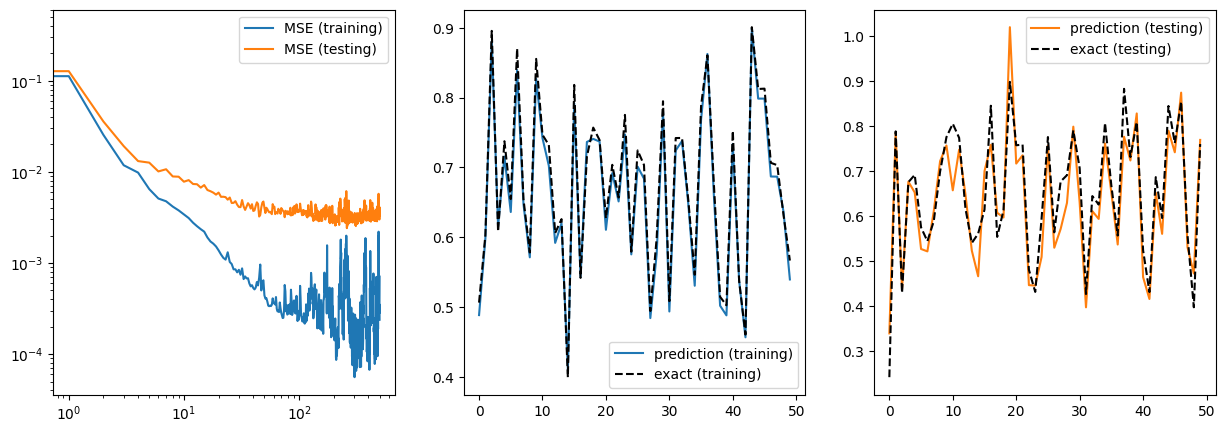

In [25]:
# Setup (data):
d = 5
n = 20 * d
eta = 1e-2
data = "sphere"
X, y = get_dataset(data, n, d, eta)
XX, yy = get_dataset(data, n, d, eta, seed=43)

# Setup (NN):
d1 = 2 * d
L = 2
act = ReLU()

# Setup (optim):
lr = 1e-2
bs = n // 10
ep = 5000 * bs // n
op = "Adam"
sf = "permutation"

# Initialize:
weights, biases = init(d, d1, L)

# Optimize:
t0 = time.time()
error_train, error_test = stochastic_gradient_descent(
    X,
    y,
    XX,
    yy,
    weights,
    biases,
    optimizer=op,
    shuffle=sf,
    batch_size=bs,
    learning_rate=lr,
    epoch=ep,
    activation=act,
)
t1 = time.time()
print(f"Time:           {t1-t0:.2f}s")

# Compute prediction and errors:
_, A = forward_pass_deep(X, weights, biases, act)
_, AA = forward_pass_deep(XX, weights, biases, act)
print(f"MSE (training): {np.square(A[-1][0] - y).mean():.2e}")
print(f"MSE (testing):  {np.square(AA[-1][0] - yy).mean():.2e}")

# Plot:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].loglog(error_train[0 :: n // bs], "-", label="MSE (training)")
axs[0].loglog(error_test[0 :: n // bs], "-", label="MSE (testing)")
axs[0].legend()
n_disp = min(n, 50)
axs[1].plot(A[-1][0][:n_disp], "-", color="tab:blue", label="prediction (training)")
axs[1].plot(y[:n_disp], "--k", label="exact (training)")
axs[1].legend()
axs[2].plot(AA[-1][0][:n_disp], "-", color="tab:orange", label="prediction (testing)")
axs[2].plot(yy[:n_disp], "--k", label="exact (testing)")
axs[2].legend()

## 2.4 The influence of the number of neurons

Here, we look at the influence of the number of neurons $d_1$.

Time: 1.61s
Time: 1.47s
Time: 1.51s
Time: 1.39s
Time: 1.46s
Time: 1.53s
Time: 1.54s


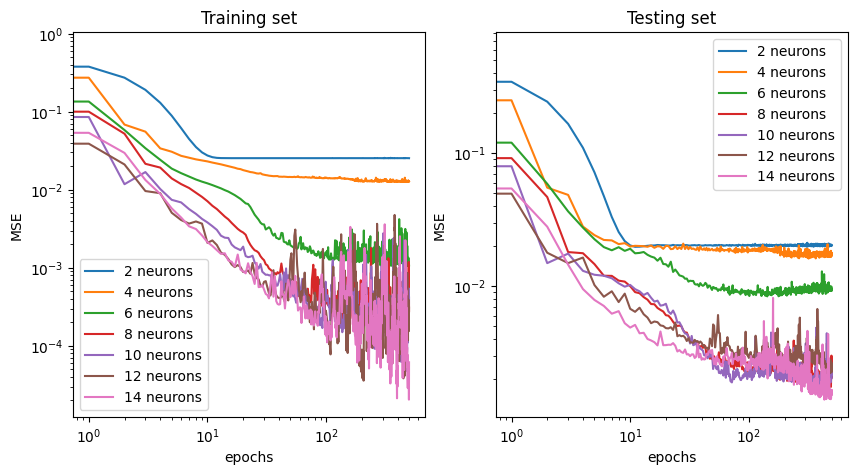

In [26]:
# Setup (data):
d = 5
n = 20 * d
eta = 1e-2
data = "sphere"
X, y = get_dataset(data, n, d, eta)
XX, yy = get_dataset(data, n, d, eta, seed=43)

# Setup (NN):
L = 2
act = ReLU()

# Setup (optim):
lr = 1e-2
bs = n // 10
ep = 5000 * bs // n
op = "Adam"
sf = "permutation"

# Loop:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for d1 in np.arange(d // 2, 6 * d // 2, d // 2):
    weights, biases = init(X.shape[1], d1, L)
    t0 = time.time()
    error_train, error_test = stochastic_gradient_descent(
        X,
        y,
        XX,
        yy,
        weights,
        biases,
        optimizer=op,
        shuffle=sf,
        batch_size=bs,
        learning_rate=lr,
        epoch=ep,
        activation=act,
    )
    t1 = time.time()
    print(f"Time: {t1-t0:.2f}s")
    axs[0].loglog(error_train[0 :: n // bs], label=f"{d1} neurons")
    axs[1].loglog(error_test[0 :: n // bs], label=f"{d1} neurons")
axs[0].set_title("Training set")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("MSE")
axs[0].legend()
axs[1].set_title("Testing set")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("MSE")
axs[1].legend()

### Exercise

{exercise}
Try different datasets and comment on what you observe.

Processing dataset: normal
Dataset: normal, Neurons: 2, Time: 1.68s
Dataset: normal, Neurons: 4, Time: 1.43s
Dataset: normal, Neurons: 6, Time: 1.45s
Dataset: normal, Neurons: 8, Time: 1.65s
Dataset: normal, Neurons: 10, Time: 1.60s
Dataset: normal, Neurons: 12, Time: 1.45s
Dataset: normal, Neurons: 14, Time: 1.54s


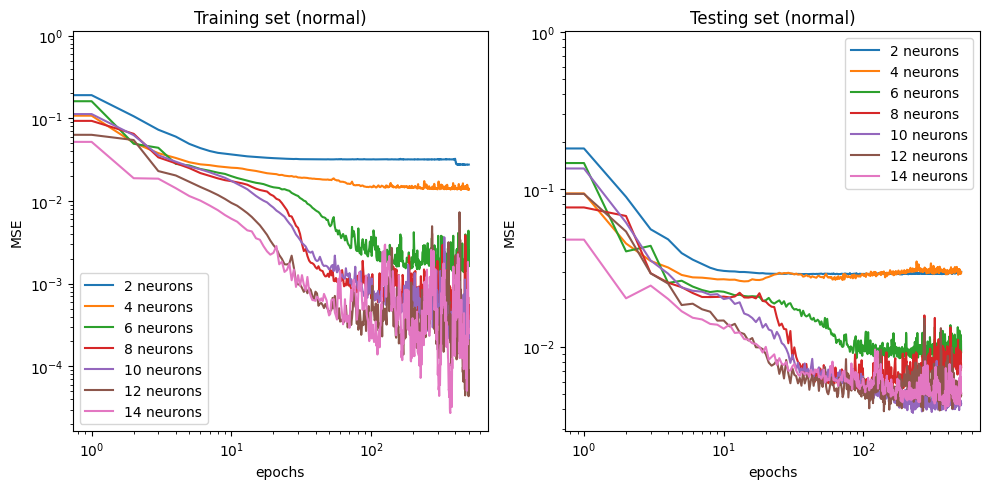

Processing dataset: linear
Dataset: linear, Neurons: 2, Time: 1.69s
Dataset: linear, Neurons: 4, Time: 1.67s
Dataset: linear, Neurons: 6, Time: 1.56s
Dataset: linear, Neurons: 8, Time: 11.74s
Dataset: linear, Neurons: 10, Time: 3.50s
Dataset: linear, Neurons: 12, Time: 1.79s
Dataset: linear, Neurons: 14, Time: 1.78s


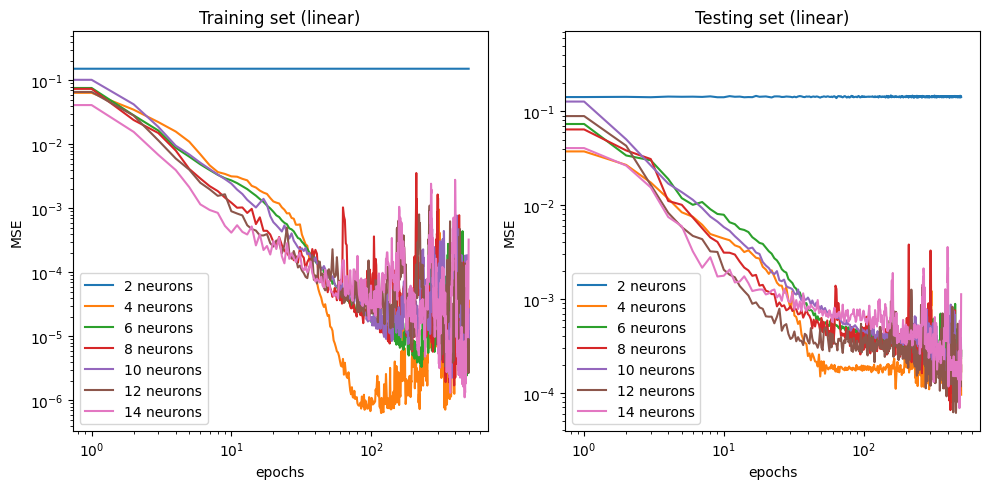

Processing dataset: logist
Dataset: logist, Neurons: 2, Time: 2.02s
Dataset: logist, Neurons: 4, Time: 1.80s
Dataset: logist, Neurons: 6, Time: 1.44s
Dataset: logist, Neurons: 8, Time: 1.40s
Dataset: logist, Neurons: 10, Time: 1.48s
Dataset: logist, Neurons: 12, Time: 1.53s
Dataset: logist, Neurons: 14, Time: 1.54s


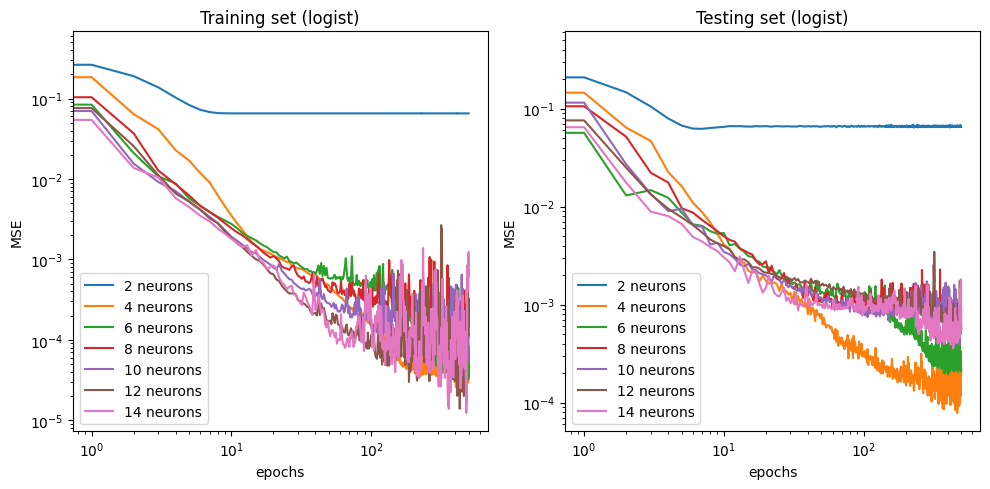

In [27]:
d = 5
n = 20 * d
eta = 1e-2


datasets = ["normal", "linear", "logist"]


for data in datasets:
    print(f"Processing dataset: {data}")
    X, y = get_dataset(data, n, d, eta)
    XX, yy = get_dataset(data, n, d, eta, seed=43)

    L = 2
    act = ReLU()

    lr = 1e-2
    bs = n // 10
    ep = 5000 * bs // n
    op = "Adam"
    sf = "permutation"

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for d1 in np.arange(d // 2, 6 * d // 2, d // 2):
        weights, biases = init(X.shape[1], d1, L)
        t0 = time.time()
        error_train, error_test = stochastic_gradient_descent(
            X,
            y,
            XX,
            yy,
            weights,
            biases,
            optimizer=op,
            shuffle=sf,
            batch_size=bs,
            learning_rate=lr,
            epoch=ep,
            activation=act,
        )
        t1 = time.time()
        print(f"Dataset: {data}, Neurons: {d1}, Time: {t1-t0:.2f}s")
        axs[0].loglog(error_train[0 :: n // bs], label=f"{d1} neurons")
        axs[1].loglog(error_test[0 :: n // bs], label=f"{d1} neurons")
    axs[0].set_title(f"Training set ({data})")
    axs[0].set_xlabel("epochs")
    axs[0].set_ylabel("MSE")
    axs[0].legend()
    axs[1].set_title(f"Testing set ({data})")
    axs[1].set_xlabel("epochs")
    axs[1].set_ylabel("MSE")
    axs[1].legend()
    plt.tight_layout()
    plt.show()


**Comments on exercice 7:** 

- **Training Error:** Across all datasets, $MSE_{train}$ tends to decrease with increasing model complexity, as expected, due to the network's improved ability to minimize error.
- **Testing Error:** For datasets like **linear** and **logist**, $MSE_{test}$ stabilizes or oscillates for larger networks, suggesting overfitting. We see that sometimes for larger networks, the error is greater than for smaller ones. While larger networks reduce the training error, their impact on generalization depends on the dataset's structure.

Then, it is important to balance model complexity and regularization to optimize both training and testing performance.


## 2.5 The influence of the number of hidden layers

### Exercise

{exercise}
Set up a numerical experiement to illustrate the influence of the number of layers $L$ and comment on what you observe.

Processing dataset: sphere
Dataset: sphere, Layers: 1, Time: 1.22s
Dataset: sphere, Layers: 2, Time: 1.61s
Dataset: sphere, Layers: 3, Time: 1.89s
Dataset: sphere, Layers: 4, Time: 2.65s
Dataset: sphere, Layers: 5, Time: 3.18s


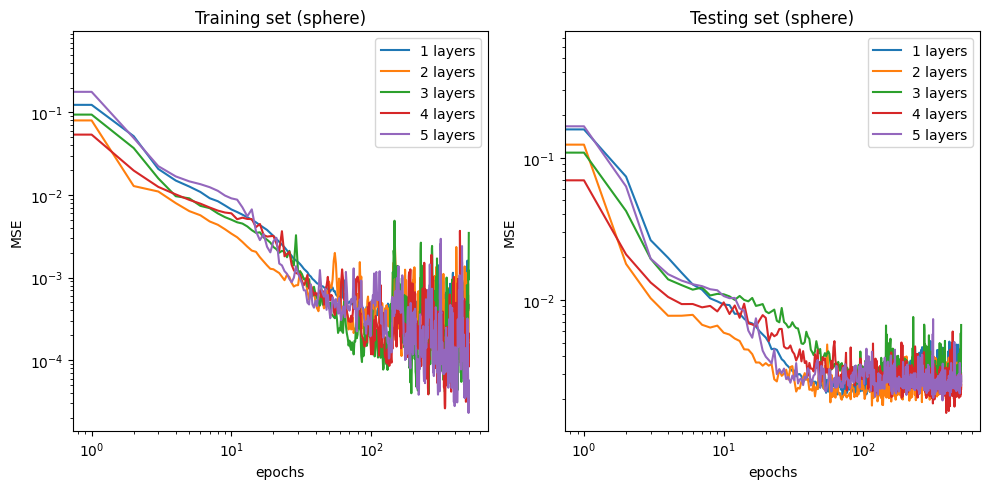

Processing dataset: normal
Dataset: normal, Layers: 1, Time: 1.02s
Dataset: normal, Layers: 2, Time: 1.58s
Dataset: normal, Layers: 3, Time: 2.04s
Dataset: normal, Layers: 4, Time: 2.50s
Dataset: normal, Layers: 5, Time: 3.03s


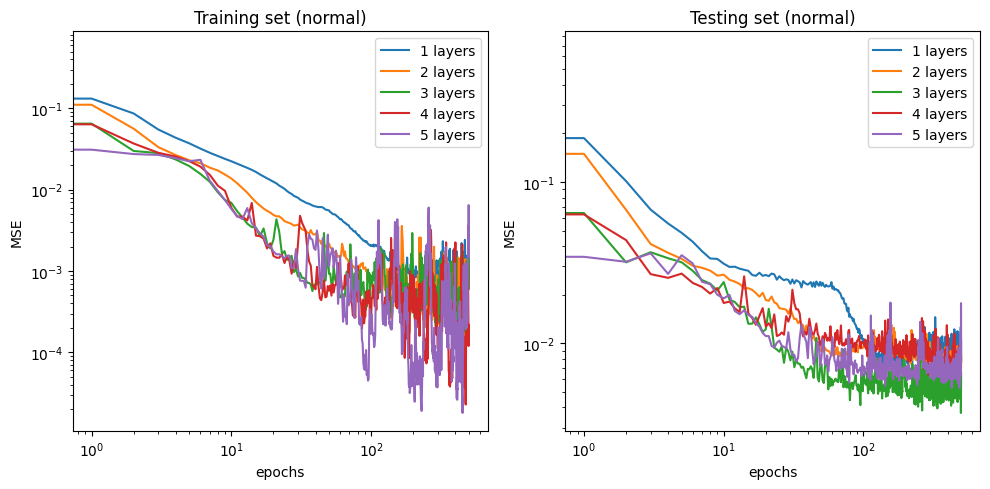

Processing dataset: linear
Dataset: linear, Layers: 1, Time: 1.09s
Dataset: linear, Layers: 2, Time: 1.57s
Dataset: linear, Layers: 3, Time: 1.86s
Dataset: linear, Layers: 4, Time: 2.49s
Dataset: linear, Layers: 5, Time: 2.83s


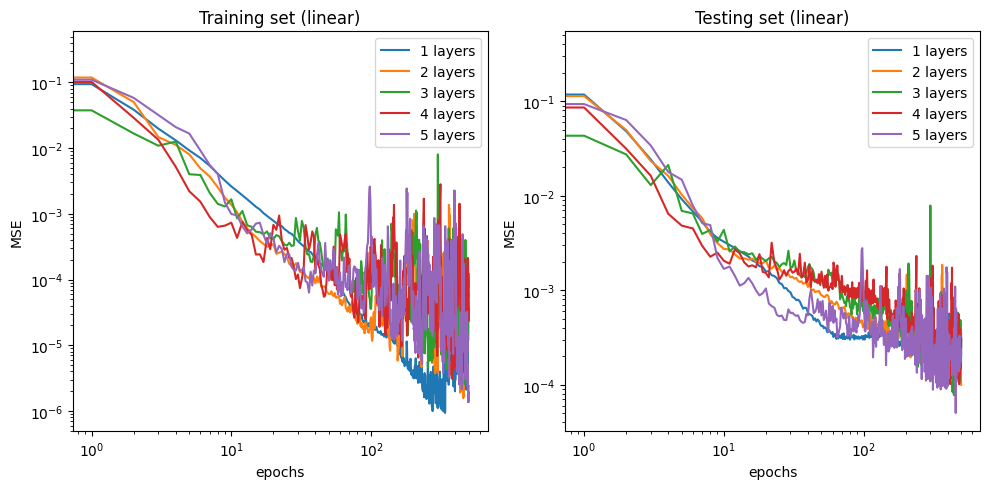

Processing dataset: logist
Dataset: logist, Layers: 1, Time: 0.95s
Dataset: logist, Layers: 2, Time: 1.44s
Dataset: logist, Layers: 3, Time: 1.90s
Dataset: logist, Layers: 4, Time: 2.34s
Dataset: logist, Layers: 5, Time: 2.74s


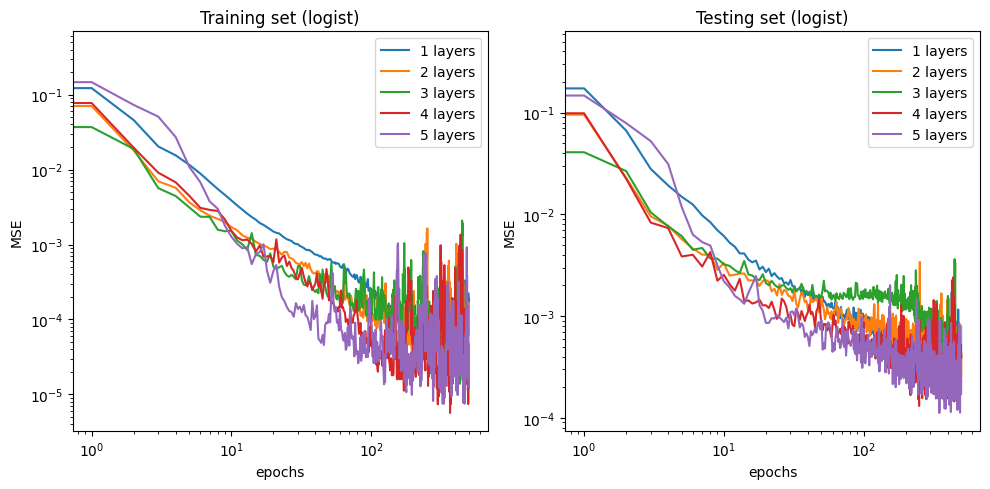

In [28]:
d = 5
n = 20 * d
eta = 1e-2

datasets = ["sphere", "normal", "linear", "logist"]

for data in datasets:
    print(f"Processing dataset: {data}")
    X, y = get_dataset(data, n, d, eta)
    XX, yy = get_dataset(data, n, d, eta, seed=43)

    lr = 1e-2
    bs = n // 10
    ep = 5000 * bs // n
    op = "Adam"
    sf = "permutation"

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for L in range(1, 6):  # Varying the number of layers from 1 to 5
        act = ReLU()
        weights, biases = init(X.shape[1], 2 * d, L)  # Fixed number of neurons

        t0 = time.time()
        error_train, error_test = stochastic_gradient_descent(
            X,
            y,
            XX,
            yy,
            weights,
            biases,
            optimizer=op,
            shuffle=sf,
            batch_size=bs,
            learning_rate=lr,
            epoch=ep,
            activation=act,
        )
        t1 = time.time()
        print(f"Dataset: {data}, Layers: {L}, Time: {t1-t0:.2f}s")

        axs[0].loglog(error_train[0 :: n // bs], label=f"{L} layers")
        axs[1].loglog(error_test[0 :: n // bs], label=f"{L} layers")

    axs[0].set_title(f"Training set ({data})")
    axs[0].set_xlabel("epochs")
    axs[0].set_ylabel("MSE")
    axs[0].legend()
    axs[1].set_title(f"Testing set ({data})")
    axs[1].set_xlabel("epochs")
    axs[1].set_ylabel("MSE")
    axs[1].legend()
    plt.tight_layout()
    plt.show()

# Comments on exercise 8:

For datasets like **linear** or **normal**, the best models do not have the most layers. Thus, overfitting becomes more apparent as the number of layers increases.

The influence of the number of layers depends on the dataset's structure. While deeper networks can improve model capacity, one has to be careful concerning overfitting.

## 2.6 The influence of the dataset size

### Exercise

{exercise}
Set up a numerical experiement to illustrate the influence of the dataset size $n$ and comment on what you observe.

Processing dataset: sphere
  Processing dataset size: 50
    Dataset size: 50, Time: 1.95s
  Processing dataset size: 100
    Dataset size: 100, Time: 2.04s
  Processing dataset size: 250
    Dataset size: 250, Time: 1.82s
  Processing dataset size: 500
    Dataset size: 500, Time: 2.03s
  Processing dataset size: 1000
    Dataset size: 1000, Time: 7.96s


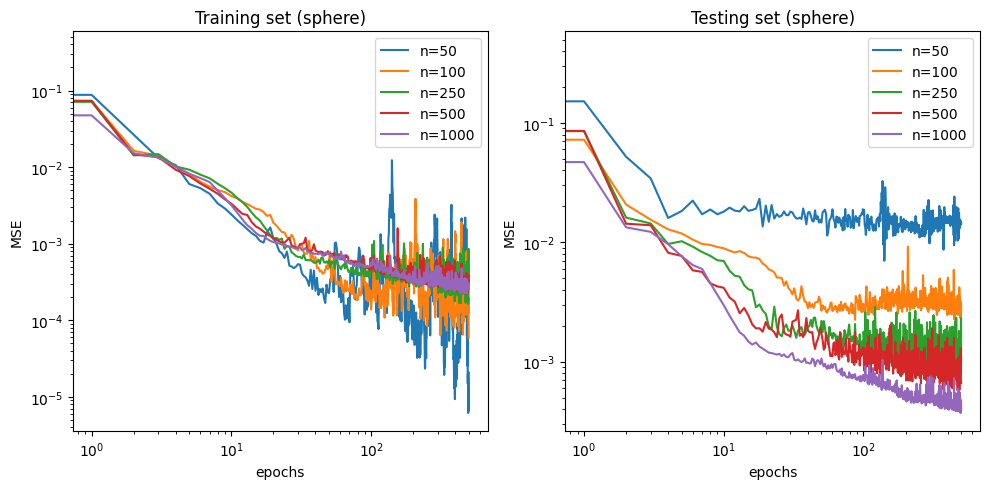

Processing dataset: normal
  Processing dataset size: 50
    Dataset size: 50, Time: 1.44s
  Processing dataset size: 100
    Dataset size: 100, Time: 1.43s
  Processing dataset size: 250
    Dataset size: 250, Time: 1.60s
  Processing dataset size: 500
    Dataset size: 500, Time: 1.87s
  Processing dataset size: 1000
    Dataset size: 1000, Time: 7.65s


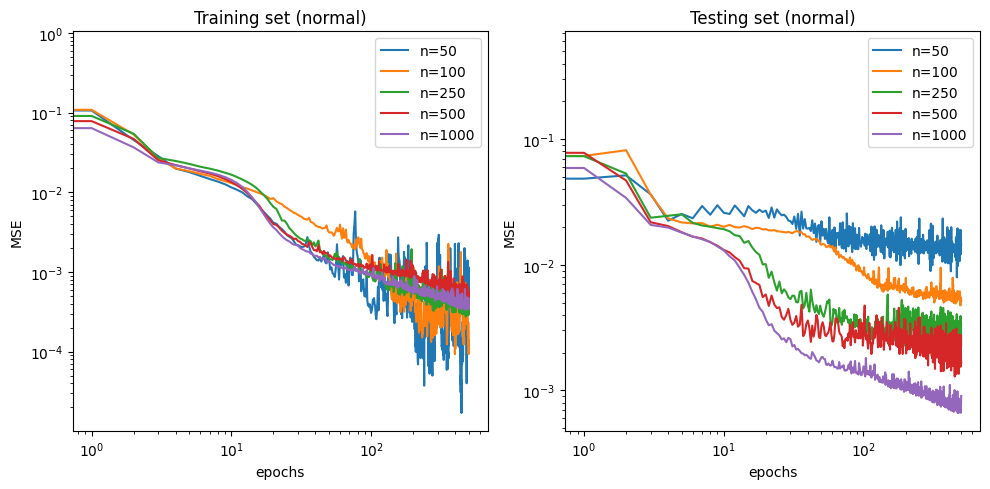

Processing dataset: linear
  Processing dataset size: 50
    Dataset size: 50, Time: 1.48s
  Processing dataset size: 100
    Dataset size: 100, Time: 1.64s
  Processing dataset size: 250
    Dataset size: 250, Time: 1.88s
  Processing dataset size: 500
    Dataset size: 500, Time: 2.06s
  Processing dataset size: 1000
    Dataset size: 1000, Time: 9.19s


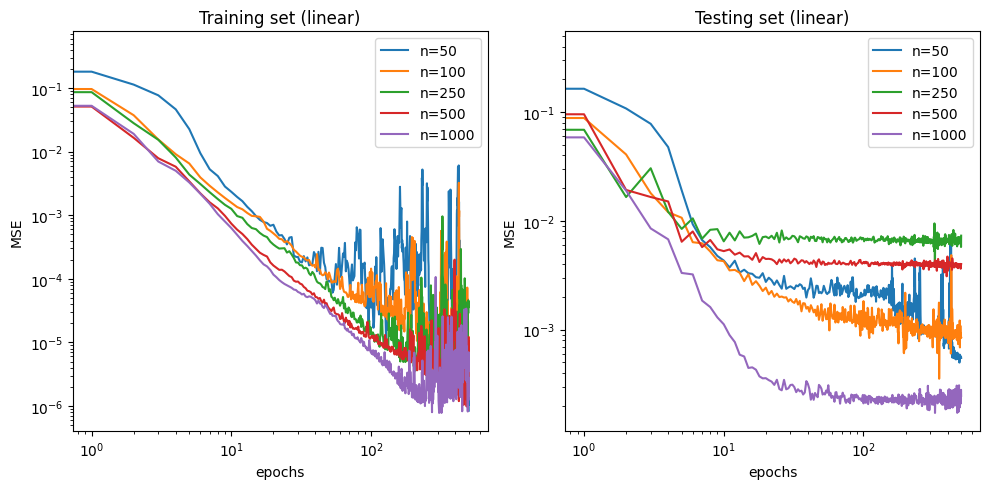

Processing dataset: logist
  Processing dataset size: 50
    Dataset size: 50, Time: 1.76s
  Processing dataset size: 100
    Dataset size: 100, Time: 1.86s
  Processing dataset size: 250
    Dataset size: 250, Time: 1.99s
  Processing dataset size: 500
    Dataset size: 500, Time: 2.09s
  Processing dataset size: 1000
    Dataset size: 1000, Time: 8.89s


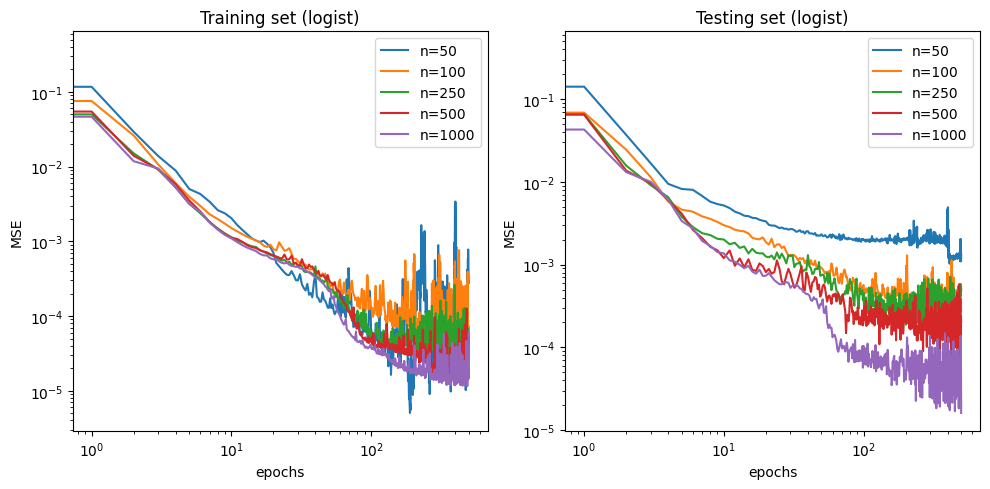

In [29]:
d = 5
eta = 1e-2


datasets = ["sphere", "normal", "linear", "logist"]  
sizes = [10 * d, 20 * d, 50 * d, 100 * d, 200 * d]  # Varying dataset sizes

L = 2
act = ReLU()
lr = 1e-2
op = "Adam"
sf = "permutation"

for dataset in datasets:
    print(f"Processing dataset: {dataset}")
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for n in sizes:
        print(f"  Processing dataset size: {n}")
        X, y = get_dataset(dataset, n, d, eta)
        XX, yy = get_dataset(dataset, n, d, eta, seed=43)

        bs = n // 10
        ep = 5000 * bs // n

        weights, biases = init(X.shape[1], 2 * d, L)

        t0 = time.time()
        error_train, error_test = stochastic_gradient_descent(
            X,
            y,
            XX,
            yy,
            weights,
            biases,
            optimizer=op,
            shuffle=sf,
            batch_size=bs,
            learning_rate=lr,
            epoch=ep,
            activation=act,
        )
        t1 = time.time()
        print(f"    Dataset size: {n}, Time: {t1-t0:.2f}s")

        axs[0].loglog(error_train[0 :: n // bs], label=f"n={n}")
        axs[1].loglog(error_test[0 :: n // bs], label=f"n={n}")

    axs[0].set_title(f"Training set ({dataset})")
    axs[0].set_xlabel("epochs")
    axs[0].set_ylabel("MSE")
    axs[0].legend()
    axs[1].set_title(f"Testing set ({dataset})")
    axs[1].set_xlabel("epochs")
    axs[1].set_ylabel("MSE")
    axs[1].legend()
    plt.tight_layout()
    plt.show()


# Comments on exercice 9:

- For most datasets (**sphere**, **normal**, **logist**), the **training error** and **testing error** consistently decrease as the dataset size increases. This is expected because larger datasets provide more information to the model and help reduce overfitting.

- In the case of the **linear** dataset, an anomaly is observed: for $n = 50$ (and $n=100$), the testing error is lower than for $n = 500$.
- This can be explained by the fact that the **linear** dataset is  simple, with a straightforward relationship between inputs and outputs. When $n = 50$, the model has sufficient data to generalize well without overfitting. However, with $n = 500$, the model might start fitting noise leading to a slight increase in testing error. This is a form of overfitting, even though the training error continues to decrease.


## 2.7 The influence of the batch size

### Exercise

{exercise}
Set up a numerical experiement to illustrate the influence of the batch size and comment on what you observe.

Processing dataset: sphere
  Processing batch size: 1
    Batch size: 1, Time: 17.42s
  Processing batch size: 5
    Batch size: 5, Time: 3.38s
  Processing batch size: 50
    Batch size: 50, Time: 0.36s
  Processing batch size: 250
    Batch size: 250, Time: 0.09s
  Processing batch size: 500
    Batch size: 500, Time: 0.06s


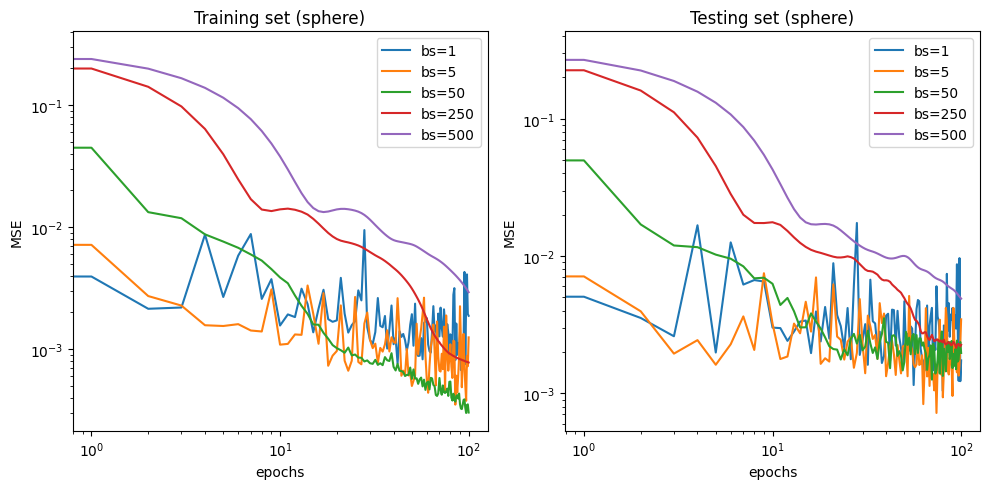

Processing dataset: normal
  Processing batch size: 1
    Batch size: 1, Time: 16.63s
  Processing batch size: 5
    Batch size: 5, Time: 3.39s
  Processing batch size: 50
    Batch size: 50, Time: 0.38s
  Processing batch size: 250
    Batch size: 250, Time: 0.10s
  Processing batch size: 500
    Batch size: 500, Time: 0.07s


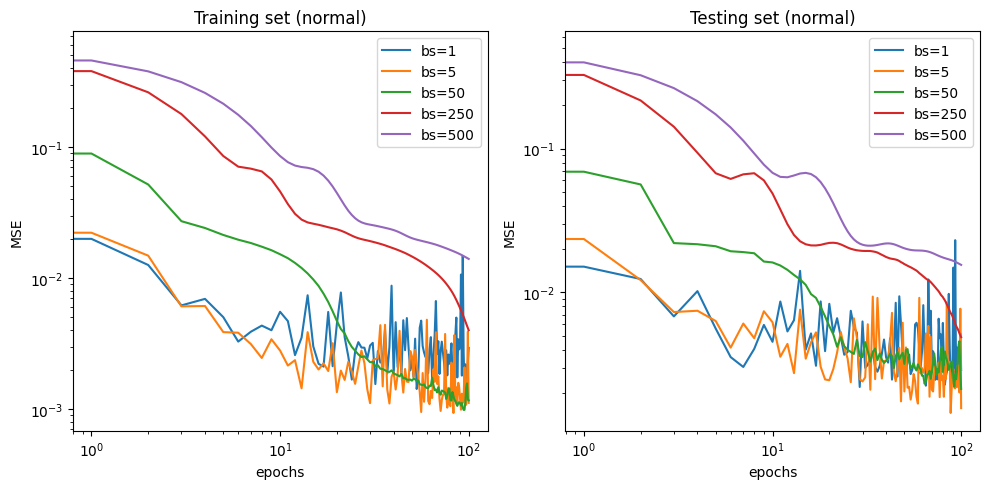

Processing dataset: linear
  Processing batch size: 1
    Batch size: 1, Time: 17.25s
  Processing batch size: 5
    Batch size: 5, Time: 3.56s
  Processing batch size: 50
    Batch size: 50, Time: 0.35s
  Processing batch size: 250
    Batch size: 250, Time: 0.10s
  Processing batch size: 500
    Batch size: 500, Time: 0.06s


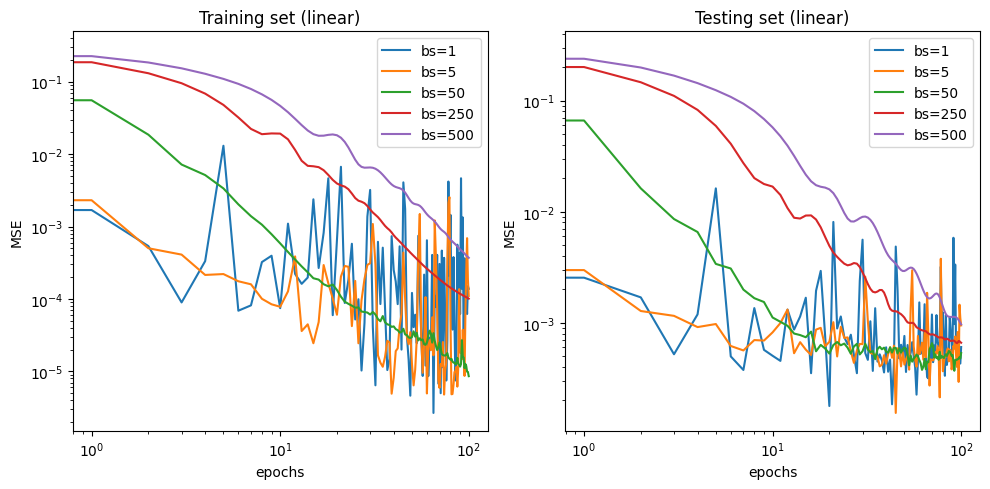

Processing dataset: logist
  Processing batch size: 1
    Batch size: 1, Time: 17.38s
  Processing batch size: 5
    Batch size: 5, Time: 3.48s
  Processing batch size: 50
    Batch size: 50, Time: 0.37s
  Processing batch size: 250
    Batch size: 250, Time: 0.09s
  Processing batch size: 500
    Batch size: 500, Time: 0.06s


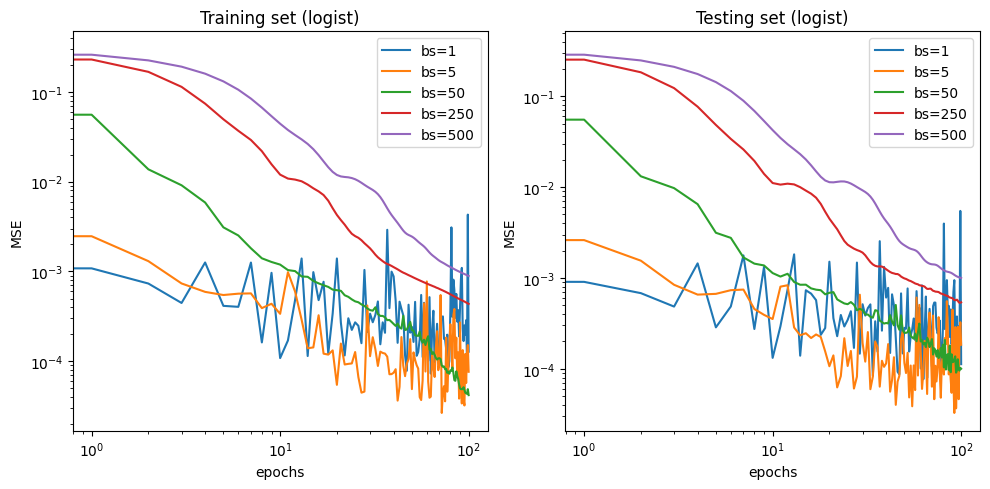

In [30]:
d = 5
n = 100 * d  # Fixed dataset size
eta = 1e-2
datasets = ["sphere", "normal", "linear", "logist"]  

batch_sizes = [1, n // 100, n // 10, n // 2, n]  # Varying batch sizes

L = 2
act = ReLU()
lr = 1e-2
op = "Adam"
sf = "permutation"

for dataset in datasets:
    print(f"Processing dataset: {dataset}")
    X, y = get_dataset(dataset, n, d, eta)
    XX, yy = get_dataset(dataset, n, d, eta, seed=43)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for bs in batch_sizes:
        print(f"  Processing batch size: {bs}")

        ep = 100

        weights, biases = init(X.shape[1], 2 * d, L)

        # Optimize
        t0 = time.time()
        error_train, error_test = stochastic_gradient_descent(
            X,
            y,
            XX,
            yy,
            weights,
            biases,
            optimizer=op,
            shuffle=sf,
            batch_size=bs,
            learning_rate=lr,
            epoch=ep,
            activation=act,
        )
        t1 = time.time()
        print(f"    Batch size: {bs}, Time: {t1-t0:.2f}s")

        axs[0].loglog(error_train[0 :: n // bs], label=f"bs={bs}")
        axs[1].loglog(error_test[0 :: n // bs], label=f"bs={bs}")

    axs[0].set_title(f"Training set ({dataset})")
    axs[0].set_xlabel("epochs")
    axs[0].set_ylabel("MSE")
    axs[0].legend()
    axs[1].set_title(f"Testing set ({dataset})")
    axs[1].set_xlabel("epochs")
    axs[1].set_ylabel("MSE")
    axs[1].legend()
    plt.tight_layout()
    plt.show()

# Comments on exercice 10: 
- Smaller batch sizes are beneficial for faster convergence and better generalization but at the cost of increased computation time and higher variance in error curves.
- The choice of batch size should balance computational efficiency and generalization performance, depending on the dataset complexity and training constraints.